Yelnur Shauketbek: Recurrent Neural Network for classification (positive/negative)

In [1]:
import torch
from torch import nn
from torch.nn import Embedding, RNN, LSTM, GRU, Linear, Transformer
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision.transforms import Lambda
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)

In [2]:
train, test = IMDB(root="dataset", split=('train', 'test'))
Tr, Ts = list(train), list(test)
rng.shuffle(Tr)
rng.shuffle(Ts)
len_train, len_val, len_test = 25000, 12500, 12500 # Whole data
train_data, val_data, test_data = Tr[:len_train], Ts[:len_val], Ts[len_val:len_val+len_test]

In [3]:
len(train_data), len(val_data), len(test_data)

(25000, 12500, 12500)

In [4]:
idx = 10
label_samp, text_samp = train_data[idx]
print(f"text: {text_samp}")
print(f"label: {label_samp}")

text: Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10
label: 1


In [5]:
datasets = {'train':train_data, 'val':val_data, 'test':test_data}
for key in datasets:
  label_dist = {}
  dataset = datasets[key]
  for lb, txt in dataset:
    if lb not in label_dist:
      label_dist.setdefault(lb, 1)
    else:
      label_dist[lb] += 1
  print(f"{key}:")
  print(label_dist)


train:
{1: 12500, 2: 12500}
val:
{2: 6245, 1: 6255}
test:
{2: 6255, 1: 6245}


In [6]:
tokenizer = get_tokenizer('basic_english')

def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<oov>", "<sos>"], max_tokens=10000)
vocab.set_default_index(vocab["<oov>"])
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 10000 tokens-index pairs.


In [7]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [8]:
print(vocab.get_itos())  # top 10000 freq words (including special chars)

['<oov>', '<sos>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', ')', '(', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', '!', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'can', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'would', 'time', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'we', 'were', 'me', 'than', 'well', 'much', '-', 'get', 'been', 'people', 'will', 'also', 'other', 'bad', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'don', 'most', 'its', 'made', 'then', 'them', 'way', 'could', 'make', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'never', 'little', 'plot', 'acting', 'where', 'best', 'love', 'did', 'life', 'show', 'know', 'does', 'ever', 'here',

In [9]:
word_index = {k:v for (k, v) in enumerate(vocab.get_itos())}

In [10]:
def decode_review(word_ids):
    return " ".join([word_index.get(word_id, "<err>") for word_id in word_ids])

print(text_samp)
print("\n")
print(decode_review(text_pipeline(text_samp)))

Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10


assuming this won ' t end up a straight-to-video release , i would have to say void

In [11]:
def sent_padding(sent_vec, maxlen):
  sent_vec = torch.tensor(sent_vec)
  maxlen -= len(sent_vec)
  return F.pad(sent_vec, (maxlen, 0))


print(sent_padding([1,2,3], maxlen=6))
print(sent_padding([1,2,3,4,5,6,7,8,9], maxlen=6))

tensor([0, 0, 0, 1, 2, 3])
tensor([4, 5, 6, 7, 8, 9])


In [12]:
seq_len = 500
sent_padding(text_pipeline(text_samp), maxlen=seq_len)

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
class CustomDataset(Dataset):
  
  def __init__(self, dataset, seq_len=seq_len):
    super().__init__()
    self.dataset = dataset
    self.seq_len = seq_len
  
  def __len__(self):
    return len(self.dataset) 
  
  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    label = label_pipeline(label)
    txt_rep = sent_padding(text_pipeline(text), maxlen=self.seq_len)
    label, txt_rep = torch.tensor(label, dtype=torch.float32), torch.tensor(txt_rep, dtype=torch.long)
    return label.to(device), txt_rep.to(device)

In [15]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

In [16]:
batch_size=256
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

In [30]:
class My_RNN(nn.Module):
  def __init__(self, vocab_length, emb_dim, hidden_size, num_layers,
               batch_size, RNN_type, bidirectional, device=device):
    super().__init__()
    self.emb_in_dim = vocab_length  # 10000
    self.emb_out_dim = emb_dim  # 10
    self.hidden_size = hidden_size 
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.batch_size = batch_size
    self.RNN_type = RNN_type
    self.target_size = 1  # binary classification
    self.device = device
    self.D = 2 if self.bidirectional else 1  # enable/disable bidirectional
    
    valid_types = {'Simple RNN':RNN, 'LSTM':LSTM, 'GRU':GRU}
    assert self.RNN_type in valid_types.keys(), f'You must choose one of {valid_types.keys()} types'
    
    self.embedding = Embedding(self.emb_in_dim, self.emb_out_dim) 
    
    chosen_rnn = valid_types[self.RNN_type]
    self.rnn = chosen_rnn(input_size=self.emb_out_dim, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, bidirectional = self.bidirectional)
    
    self.linear = Linear(self.D*self.hidden_size, self.target_size)

  def forward(self, x):
    #x: (batch_size, 500)
    self.embeds = self.embedding(x)
    #embeds: (batch_size, 500, 10)
    #But rnn receives inputs of: (500, batch_size, 10) (seq_len, batch_size, H_in)
    self.embeds = self.embeds.permute(1, 0, 2)
    #embeds: (500, batch_size, 10) -> Now the shape is correct
    rnn_out, self.last_hidden = self.rnn(self.embeds)
    #rnn_out: (500, 256, 2*5:10) -> (seq_len, batch_size, D*hidden_size)
    #h_n: (1, 256, hidden_size) -> (D*num_layers, batch_size, hidden_size)
    output = self.linear(rnn_out[-1, :, :])
    #output: (256, 1) -> (batch_size, target_size)
    output = output.flatten()
    #output: (256) -> (batch_size)
    return F.sigmoid(output)

In [31]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'Simple RNN' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss() #[TO COMPLETE]     
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [32]:
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─RNN: 1-2                               1,408
├─Linear: 1-3                            33
Total params: 101,441
Trainable params: 101,441
Non-trainable params: 0

In [33]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()
      
      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [34]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 53.00%, Loss: 0.68837208 ---------------- Val_Acc: 54.54%, Val_Loss: 0.68418026
epoch: 2 -> Accuracy: 56.76%, Loss: 0.67642438 ---------------- Val_Acc: 53.54%, Val_Loss: 0.69348347
epoch: 3 -> Accuracy: 60.49%, Loss: 0.65937054 ---------------- Val_Acc: 58.86%, Val_Loss: 0.68303841
epoch: 4 -> Accuracy: 60.36%, Loss: 0.65815616 ---------------- Val_Acc: 62.06%, Val_Loss: 0.65177196
epoch: 5 -> Accuracy: 65.66%, Loss: 0.62480968 ---------------- Val_Acc: 65.09%, Val_Loss: 0.63491982
epoch: 6 -> Accuracy: 65.75%, Loss: 0.62348175 ---------------- Val_Acc: 66.37%, Val_Loss: 0.62583232
epoch: 7 -> Accuracy: 69.52%, Loss: 0.58795393 ---------------- Val_Acc: 67.47%, Val_Loss: 0.62142926
epoch: 8 -> Accuracy: 70.00%, Loss: 0.58513194 ---------------- Val_Acc: 68.94%, Val_Loss: 0.59722733
epoch: 9 -> Accuracy: 72.72%, Loss: 0.55063182 ---------------- Val_Acc: 69.50%, Val_Loss: 0.59450376
epoch: 10 -> Accuracy: 74.37%, Loss: 0.53290910 ---------------- Val_Acc: 69.78%, 

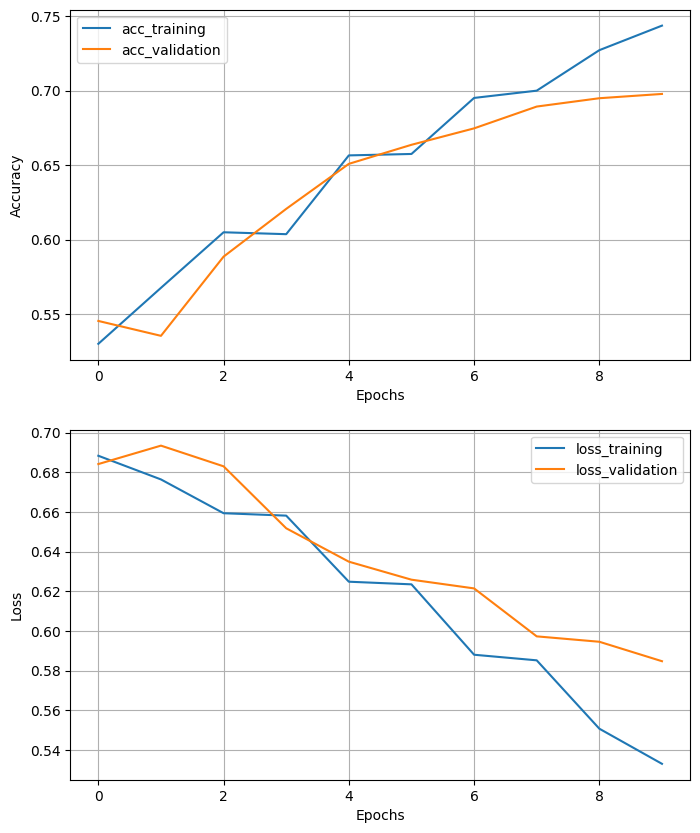

In [35]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(EPOCHS), acc_tr, label='acc_training')
    plt.plot(range(EPOCHS), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(EPOCHS), loss_tr, label='loss_training')
    plt.plot(range(EPOCHS), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [36]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")


In [37]:
test(model)

Test Loss: 0.57739913 ---------- Test Accuracy: 70.4800%


Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              5,632
├─Linear: 1-3                            33
Total params: 105,665
Trainable params: 105,665
Non-trainable params: 0
epoch: 1 -> Accuracy: 52.65%, Loss: 0.69069111 ---------------- Val_Acc: 54.70%, Val_Loss: 0.68765408
epoch: 2 -> Accuracy: 57.20%, Loss: 0.67581147 ---------------- Val_Acc: 59.03%, Val_Loss: 0.67032796
epoch: 3 -> Accuracy: 63.17%, Loss: 0.64162976 ---------------- Val_Acc: 65.25%, Val_Loss: 0.62541765
epoch: 4 -> Accuracy: 68.48%, Loss: 0.59698194 ---------------- Val_Acc: 70.10%, Val_Loss: 0.58359212
epoch: 5 -> Accuracy: 73.08%, Loss: 0.54482526 ---------------- Val_Acc: 72.46%, Val_Loss: 0.54843658
epoch: 6 -> Accuracy: 75.44%, Loss: 0.51192498 ---------------- Val_Acc: 75.38%, Val_Loss: 0.50962776
epoch: 7 -> Accuracy: 78.72%, Loss: 0.46371478 ---------------- Val_Acc: 76.22%, Va

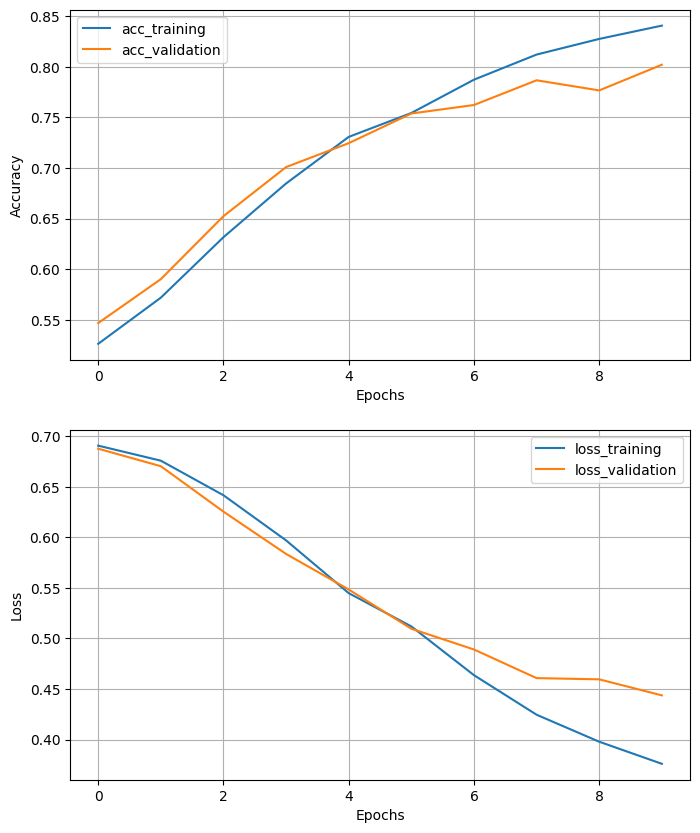

In [38]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(summary(model))

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [39]:
test(model)

Test Loss: 0.44097042 ---------- Test Accuracy: 80.5120%


Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         160,000
├─LSTM: 1-2                              14,848
├─Linear: 1-3                            33
Total params: 174,881
Trainable params: 174,881
Non-trainable params: 0
epoch: 1 -> Accuracy: 54.69%, Loss: 0.68584597 ---------------- Val_Acc: 58.29%, Val_Loss: 0.67315900
epoch: 2 -> Accuracy: 64.31%, Loss: 0.63506228 ---------------- Val_Acc: 63.10%, Val_Loss: 0.63829952
epoch: 3 -> Accuracy: 69.98%, Loss: 0.57991654 ---------------- Val_Acc: 71.93%, Val_Loss: 0.55305088
epoch: 4 -> Accuracy: 75.36%, Loss: 0.51013458 ---------------- Val_Acc: 76.53%, Val_Loss: 0.49098459
epoch: 5 -> Accuracy: 79.69%, Loss: 0.44640863 ---------------- Val_Acc: 77.32%, Val_Loss: 0.47740117
epoch: 6 -> Accuracy: 81.29%, Loss: 0.42316455 ---------------- Val_Acc: 78.14%, Val_Loss: 0.47624645
epoch: 7 -> Accuracy: 83.74%, Loss: 0.37832159 ---------------- Val_Acc: 82.56%, V

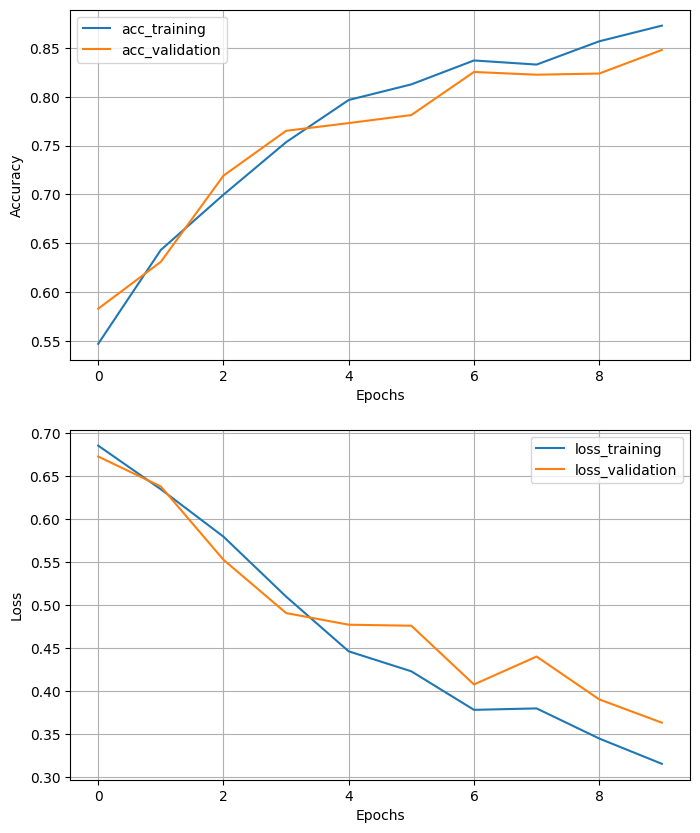

In [40]:
# [TO COMPLETE]
vocab_length = len(vocab)
emb_dim = 16
hidden_size = 32
num_layers = 2
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(summary(model))

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [41]:
test(model)

Test Loss: 0.36296251 ---------- Test Accuracy: 84.5120%


Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─GRU: 1-2                               4,224
├─Linear: 1-3                            33
Total params: 104,257
Trainable params: 104,257
Non-trainable params: 0
epoch: 1 -> Accuracy: 53.60%, Loss: 0.68847662 ---------------- Val_Acc: 55.34%, Val_Loss: 0.68310398
epoch: 2 -> Accuracy: 60.12%, Loss: 0.66144270 ---------------- Val_Acc: 64.34%, Val_Loss: 0.63790053
epoch: 3 -> Accuracy: 65.91%, Loss: 0.62060797 ---------------- Val_Acc: 69.48%, Val_Loss: 0.59220439
epoch: 4 -> Accuracy: 71.99%, Loss: 0.55795056 ---------------- Val_Acc: 74.17%, Val_Loss: 0.53568190
epoch: 5 -> Accuracy: 76.51%, Loss: 0.50103986 ---------------- Val_Acc: 76.22%, Val_Loss: 0.50075144
epoch: 6 -> Accuracy: 79.52%, Loss: 0.45021075 ---------------- Val_Acc: 79.58%, Val_Loss: 0.44891727
epoch: 7 -> Accuracy: 82.27%, Loss: 0.40882224 ---------------- Val_Acc: 80.66%, Va

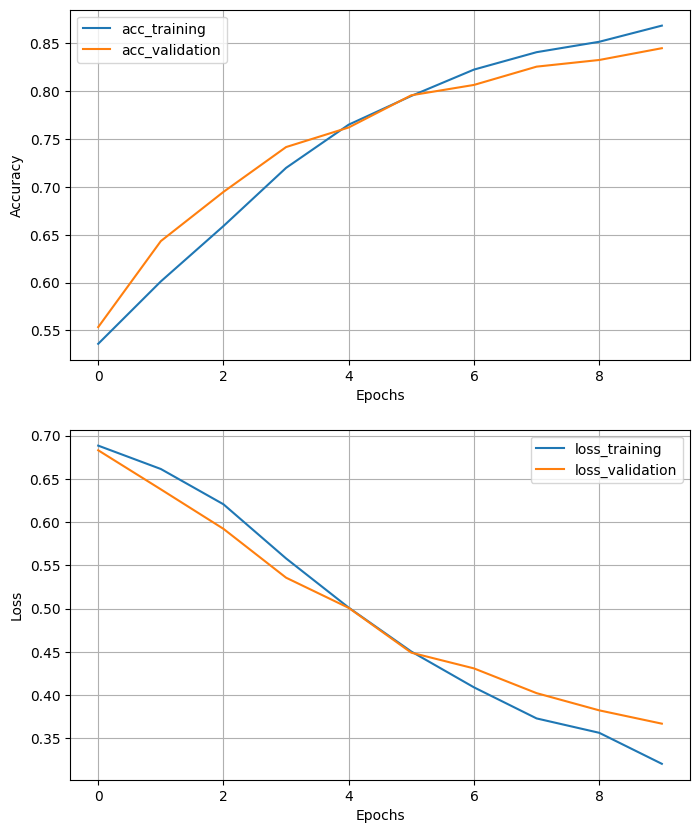

Test Loss: 0.36772195 ---------- Test Accuracy: 84.5680%
None


In [42]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'GRU' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(summary(model))

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

print(test(model))

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         160,000
├─GRU: 1-2                               11,136
├─Linear: 1-3                            33
Total params: 171,169
Trainable params: 171,169
Non-trainable params: 0
epoch: 1 -> Accuracy: 54.94%, Loss: 0.68330514 ---------------- Val_Acc: 57.76%, Val_Loss: 0.67369741
epoch: 2 -> Accuracy: 63.44%, Loss: 0.63593924 ---------------- Val_Acc: 67.93%, Val_Loss: 0.60214686
epoch: 3 -> Accuracy: 71.85%, Loss: 0.55783170 ---------------- Val_Acc: 73.10%, Val_Loss: 0.53968817
epoch: 4 -> Accuracy: 77.81%, Loss: 0.47476965 ---------------- Val_Acc: 78.01%, Val_Loss: 0.47582474
epoch: 5 -> Accuracy: 81.44%, Loss: 0.41428661 ---------------- Val_Acc: 80.55%, Val_Loss: 0.42613894
epoch: 6 -> Accuracy: 84.24%, Loss: 0.36484554 ---------------- Val_Acc: 82.92%, Val_Loss: 0.38869551
epoch: 7 -> Accuracy: 85.80%, Loss: 0.33623400 ---------------- Val_Acc: 82.35%, V

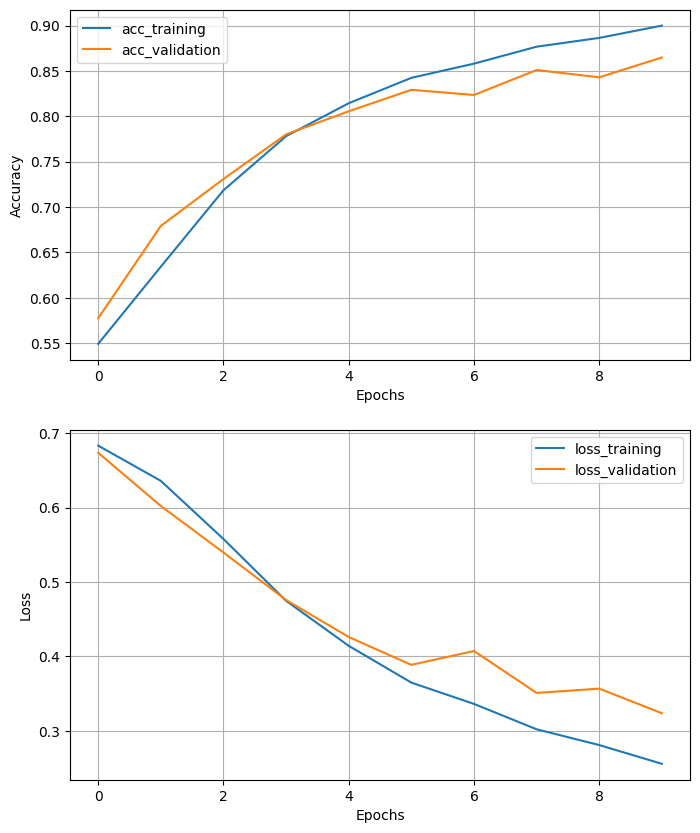

Test Loss: 0.32020831 ---------- Test Accuracy: 86.6400%
None


In [43]:
# [TO COMPLETE]
vocab_length = len(vocab)
emb_dim = 16
hidden_size = 32
num_layers = 2
RNN_type = 'GRU' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(summary(model))

start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

print(test(model))

In [44]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = True

EPOCHS = 15
lr = 3e-4

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss() # COMPLETE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              11,264
├─Linear: 1-3                            65
Total params: 111,329
Trainable params: 111,329
Non-trainable params: 0

In [45]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 51.66%, Loss: 0.69137925 ---------------- Val_Acc: 52.66%, Val_Loss: 0.68995219
epoch: 2 -> Accuracy: 52.54%, Loss: 0.68966192 ---------------- Val_Acc: 53.51%, Val_Loss: 0.68831009
epoch: 3 -> Accuracy: 55.48%, Loss: 0.68343252 ---------------- Val_Acc: 59.10%, Val_Loss: 0.67013359
epoch: 4 -> Accuracy: 60.27%, Loss: 0.66278636 ---------------- Val_Acc: 62.13%, Val_Loss: 0.65381068
epoch: 5 -> Accuracy: 62.25%, Loss: 0.65077657 ---------------- Val_Acc: 63.16%, Val_Loss: 0.64514714
epoch: 6 -> Accuracy: 62.01%, Loss: 0.65092379 ---------------- Val_Acc: 64.02%, Val_Loss: 0.64381135
epoch: 7 -> Accuracy: 63.90%, Loss: 0.63995200 ---------------- Val_Acc: 64.23%, Val_Loss: 0.63806182
epoch: 8 -> Accuracy: 64.94%, Loss: 0.63127565 ---------------- Val_Acc: 64.65%, Val_Loss: 0.63147008
epoch: 9 -> Accuracy: 64.69%, Loss: 0.63291138 ---------------- Val_Acc: 64.70%, Val_Loss: 0.63104171
epoch: 10 -> Accuracy: 65.20%, Loss: 0.62717104 ---------------- Val_Acc: 65.14%, 

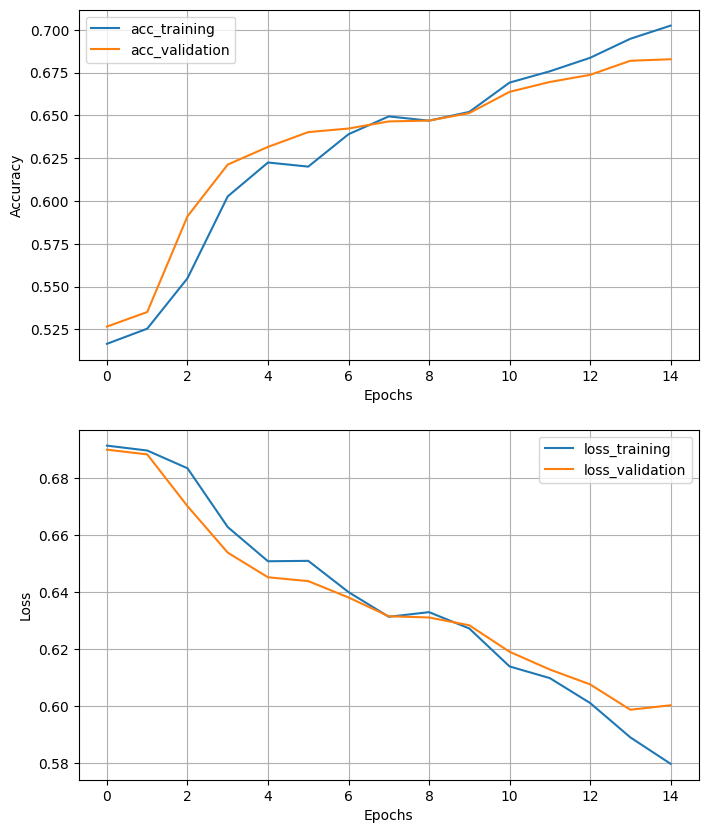

In [46]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [47]:
test(model)

Test Loss: 0.60604018 ---------- Test Accuracy: 67.8880%


In [48]:
def word_embedder(word):
  word_high_dim = sent_padding(text_pipeline(word), maxlen=seq_len).to(device)
  word_low_dim_embedded = model.embedding(word_high_dim)[-1]
  return word_low_dim_embedded

EMB_VOCAB = {}
for word in vocab.get_itos():
  EMB_VOCAB[word] =  word_embedder(word)

In [49]:
def cosine_similarity(u, v):
    return torch.dot(u,v) / (torch.sqrt(torch.sum(u * u)) * torch.sqrt(torch.sum(v * v)))

def word_matcher(ref1, ref2, tgt3, candidates, EMB_VOCAB):
  max_thr = -np.inf
  e_ref1, e_ref2, e_tgt3 = EMB_VOCAB[ref1], EMB_VOCAB[ref2], EMB_VOCAB[tgt3]
  for w in candidates:
    e_w = EMB_VOCAB[w]
    sim = cosine_similarity(e_ref2 - e_ref1, e_w - e_tgt3)
    if sim > max_thr:
      result = w
      max_thr = sim
  return result

w1, w2, w3 = 'man', 'woman', 'king'
w4_cand = ['soldier', 'queen', 'prophet']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'germany', 'berlin', 'italy'
w4_cand = ['spain', 'rome', 'germany', 'france']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

The relation between man -> woman is like the realtion between king -> queen
The relation between germany -> berlin is like the realtion between italy -> spain


In [51]:
new_seq_len = 200
train_dataset_trns = CustomDataset(train_data, seq_len=new_seq_len)
val_dataset_trns = CustomDataset(val_data, seq_len=new_seq_len)
test_dataset_trns = CustomDataset(test_data, seq_len=new_seq_len)

batch_size=256
dataloader_training_trns = DataLoader(train_dataset_trns, batch_size=batch_size, shuffle=True)
dataloader_validation_trns = DataLoader(val_dataset_trns, batch_size=batch_size)
dataloader_test_trns = DataLoader(test_dataset_trns, batch_size=batch_size)

In [ ]:
class My_Transform(nn.Module):
  def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, layer_norm_eps, device=device):
    super().__init__()
    self.device = device

    self.emb_en = Embedding(num_embeddings=len(vocab), embedding_dim=d_model)
    self.emb_de = Embedding(num_embeddings=2, embedding_dim=d_model)
    #2: because of binary classification

    self.transformer = Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                   dropout=dropout, layer_norm_eps=layer_norm_eps)
    
    self.linear = Linear(d_model, 1)#1: because of binary classification

  def forward(self, x, y):

    #x: (batch_size, seq_len) -> (256, 200)
    #y: (batch_size) -> (256)

    y = torch.roll(y, shifts=1, dims=0) #right shifted

    self.embedded_src = self.emb_en(x)
    #self.embedded_src: (batch_size, seq_len, d_model) -> (256, 200, 5)

    '''
    Transformer requires src_dim and trg_dim of (S, N, E)
    (S, N, E) -> (Seq_len, Batch_size, Embed_dim) -> (seq_len, batch_size, d_model)
        - self.embedded_src must be permuted
        - self.embedded_trg must be reshaped accordingly
    Transformer will produce an output of dim (T, N, E)
    (T, N, E) -> (Target_len, Batch_size, Embed_dim) -> (1, batch_size, d_model)
    '''
    
    self.embedded_src = self.embedded_src.permute(1, 0, 2)
    #self.embedded_src: (seq_len, batch_size, d_model) -> (200, 256, 5)
    self.embedded_trg = self.emb_de(y.unsqueeze(0).long()) 
    #self.embedded_trg: (seq_len:target_len, batch_size, d_model) -> (1, 256, 5)

    trns_out = self.transformer(self.embedded_src, self.embedded_trg)
    #trns_out: (target_len, batch_size, d_model) -> (1, 256, 5)

    out = self.linear(trns_out)
    #out: (1, 256, 1)

    return F.sigmoid(out.squeeze()) #(batch_size) -> (256) : Like y

In [ ]:
d_model= 10 #[TO COMPLETE]
nhead= 5 #[TO COMPLETE]                  
num_encoder_layers= 5 #[TO COMPLETE]     
num_decoder_layers= 5 #[TO COMPLETE]     
dim_feedforward=128
dropout=0.1
layer_norm_eps=1e-5

EPOCHS = 10
lr = 1e-3

transformer = My_Transform(d_model, nhead, num_encoder_layers, num_decoder_layers,
                           dim_feedforward, dropout, layer_norm_eps).to(device)

criterion = torch.nn.BCELoss
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)

summary(transformer)

Layer (type:depth-idx)                                                 Param #
My_Transform                                                           --
├─Embedding: 1-1                                                       100,000
├─Embedding: 1-2                                                       20
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            15,890
│    │    └─LayerNorm: 3-2                                             20
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            18,190
│    │    └─LayerNorm: 3-4                                             20
├─Linear: 1-4                                                          11
Total params: 134,151
Trainable params: 134,151
Non-trainable params: 0

In [ ]:
def train_trns(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):

      optimizer.zero_grad()
      logits = model(text, label)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()
      
      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):

            logits = model(text, label)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [ ]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_trns(transformer, optimizer, dataloader_training_trns, dataloader_validation_trns, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 57.85%, Loss: 0.66875714 ---------------- Val_Acc: 63.92%, Val_Loss: 0.63382018
epoch: 2 -> Accuracy: 68.44%, Loss: 0.59478951 ---------------- Val_Acc: 71.93%, Val_Loss: 0.55660468
epoch: 3 -> Accuracy: 75.09%, Loss: 0.51926869 ---------------- Val_Acc: 76.66%, Val_Loss: 0.49532974
epoch: 4 -> Accuracy: 78.57%, Loss: 0.46659392 ---------------- Val_Acc: 78.18%, Val_Loss: 0.46447495
epoch: 5 -> Accuracy: 80.36%, Loss: 0.43170407 ---------------- Val_Acc: 79.48%, Val_Loss: 0.44830948
epoch: 6 -> Accuracy: 82.50%, Loss: 0.39750800 ---------------- Val_Acc: 80.55%, Val_Loss: 0.42296627
epoch: 7 -> Accuracy: 83.77%, Loss: 0.37328181 ---------------- Val_Acc: 80.42%, Val_Loss: 0.43911070
epoch: 8 -> Accuracy: 84.25%, Loss: 0.36106268 ---------------- Val_Acc: 82.21%, Val_Loss: 0.39747787
epoch: 9 -> Accuracy: 86.09%, Loss: 0.33294669 ---------------- Val_Acc: 82.95%, Val_Loss: 0.38939187
epoch: 10 -> Accuracy: 87.00%, Loss: 0.31139538 ---------------- Val_Acc: 83.44%, 

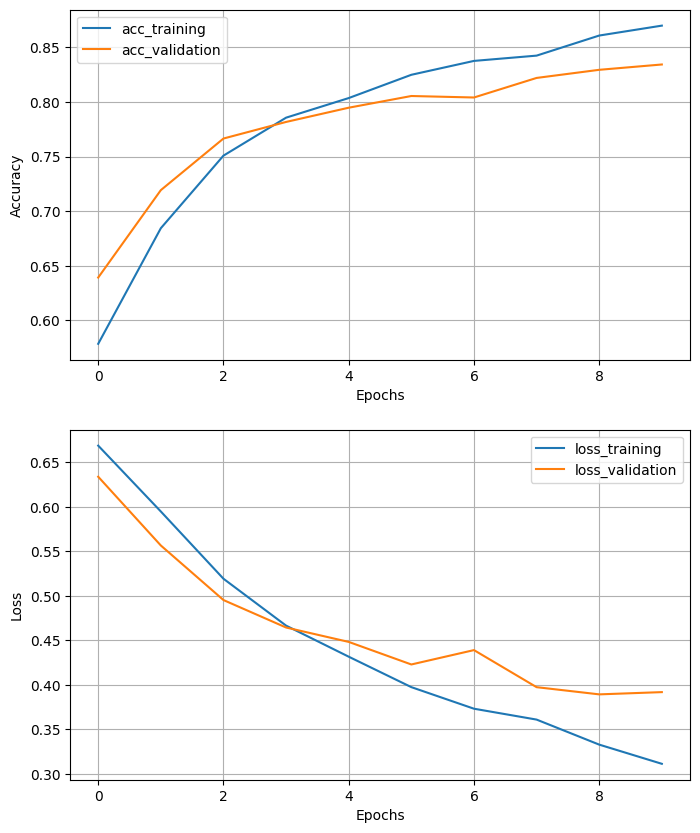

In [ ]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [ ]:
def test_trns(model, dataloader_test):
  with torch.no_grad():
    model.eval()
    total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_test):
        pre_label = model(text, label)
        loss += criterion(pre_label, label)
        labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
        pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
        total_acc_test += (pre_label == label).sum().item()
        total_count_test += label.size(0)
        n_batches_test += 1
    accuracy_test = total_acc_test/total_count_test
    loss_test = loss/n_batches_test
    print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
    print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [ ]:
gc.collect()
test_trns(transformer, dataloader_test_trns)

Test Loss: 0.37493348 ---------- Test Accuracy: 84.3200%
